# Visualizaciones Interpretables del Modelo GNN (Objetivo 7)

Este notebook genera visualizaciones avanzadas para interpretación del modelo multimodal:

1. **t-SNE/UMAP de embeddings**: Proyección 2D del espacio latente de 64 dimensiones
2. **Análisis de importancia de características**: Contribución de cada modalidad mediante ablación
3. **Visualización del grafo**: Estructura de conectividad y disponibilidad de biomarcadores
4. **Trayectorias de pacientes**: Evolución longitudinal en el espacio latente

**Requisito**: Ejecutar primero `AllBiomarkers.ipynb` para generar el modelo entrenado.

In [27]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import json

from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import networkx as nx

try:
    import umap
    UMAP_AVAILABLE = True
except ImportError:
    UMAP_AVAILABLE = False
    print("⚠️  UMAP no disponible. Instala con: pip install umap-learn")

torch.manual_seed(42)
np.random.seed(42)

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.dpi'] = 300

print("✅ Librerías cargadas correctamente")

✅ Librerías cargadas correctamente


## 1. Cargar Datos y Modelo Entrenado

In [28]:

def norm_codes_to_labels(s: pd.Series, mapping: dict) -> pd.Series:
    out = s.astype(str).str.strip().str.replace(r"\.0$", "", regex=True)
    out = out.map(mapping)
    return out

gender_map = {"1":"male","2":"female","male":"male","female":"female","m":"male","f":"female"}
marry_map  = {"1":"married","2":"widowed","3":"divorced","4":"never_married","6":"domestic_partnership"}

def to_year(s):
    s = pd.to_numeric(s, errors="coerce")
    s = s.where((s >= 1900) & (s <= 2100))
    return s

print("📂 Cargando datos...")
csv_path = "./data/adni/demographics/PTDEMOG.csv"
df = pd.read_csv(csv_path)

onset_cols = [c for c in ["PTCOGBEG","PTADBEG","PTADDX"] if c in df.columns]
for c in onset_cols:
    df[c] = to_year(df[c])

def row_min_nonnull(row):
    vals = [row[c] for c in onset_cols if pd.notna(row[c])]
    return min(vals) if vals else np.nan

df["YEAR_ONSET"] = df.apply(row_min_nonnull, axis=1) if onset_cols else np.nan
df["YEAR_ONSET"] = to_year(df["YEAR_ONSET"])

for c in ["PTDOBYY","PTEDUCAT"]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

if "PTGENDER" in df.columns:
    df["PTGENDER"] = norm_codes_to_labels(df["PTGENDER"], gender_map)
if "PTMARRY" in df.columns:
    df["PTMARRY"]  = norm_codes_to_labels(df["PTMARRY"], marry_map)

print(f"✅ Demografía cargada: {df.shape}")

📂 Cargando datos...
✅ Demografía cargada: (6210, 85)


In [29]:

biomarker_path = "./data/adni/demographics/UPENNBIOMK_ROCHE_ELECSYS_11Oct2025.csv"
df_csf = pd.read_csv(biomarker_path)
df_csf['VISCODE_NORMALIZED'] = df_csf['VISCODE2'].astype(str).str.strip()
df_csf = df_csf.dropna(subset=['ABETA42', 'TAU', 'PTAU'])
df_csf['TAU_ABETA42_RATIO'] = df_csf['TAU'] / (df_csf['ABETA42'] + 1e-6)
df_csf['PTAU_ABETA42_RATIO'] = df_csf['PTAU'] / (df_csf['ABETA42'] + 1e-6)
df_csf['PTAU_TAU_RATIO'] = df_csf['PTAU'] / (df_csf['TAU'] + 1e-6)

df['VISCODE_NORMALIZED'] = df['VISCODE2'].astype(str).str.strip().replace({'sc': 'bl', 'f': 'bl', 'nan': ''})
df = df.merge(
    df_csf[['RID', 'VISCODE_NORMALIZED', 'ABETA42', 'TAU', 'PTAU', 
            'TAU_ABETA42_RATIO', 'PTAU_ABETA42_RATIO', 'PTAU_TAU_RATIO']],
    on=['RID', 'VISCODE_NORMALIZED'],
    how='left'
)
df['HAS_CSF'] = df['ABETA42'].notna().astype(float)

pet_path = "./data/adni/demographics/All_Subjects_UCBERKELEY_AMY_6MM_11Oct2025.csv"
df_pet = pd.read_csv(pet_path, low_memory=False)
df_pet['VISCODE_NORMALIZED'] = df_pet['VISCODE'].astype(str).str.strip().replace({'sc': 'bl', 'f': 'bl', 'nan': ''})
df_pet = df_pet[['RID', 'VISCODE_NORMALIZED', 'CENTILOIDS', 'SUMMARY_SUVR', 'COMPOSITE_REF_SUVR']].copy()
df_pet.columns = ['RID', 'VISCODE_NORMALIZED', 'PET_CENTILOIDS', 'PET_SUVR', 'PET_COMPOSITE']
df_pet = df_pet.dropna(subset=['PET_CENTILOIDS', 'PET_SUVR'])

df = df.merge(df_pet, on=['RID', 'VISCODE_NORMALIZED'], how='left')
df['HAS_PET'] = df['PET_CENTILOIDS'].notna().astype(float)

mri_path = "./data/adni/demographics/All_Subjects_UCSFFSX7_11Oct2025.csv"
df_mri = pd.read_csv(mri_path, low_memory=False)
df_mri['VISCODE_NORMALIZED'] = df_mri['VISCODE2'].astype(str).str.strip().replace({'sc': 'bl', 'f': 'bl', 'nan': ''})
df_mri = df_mri[['RID', 'VISCODE_NORMALIZED', 'ST101SV', 'ST11SV', 'ST12SV', 
                 'ST4SV', 'ST5SV', 'ST17SV', 'ST18SV']].copy()
df_mri.columns = ['RID', 'VISCODE_NORMALIZED', 'MRI_eTIV', 'MRI_Vol1', 'MRI_Vol2', 
                  'MRI_Vol3', 'MRI_Vol4', 'MRI_Vol5', 'MRI_Vol6']
df_mri = df_mri.dropna(subset=['MRI_eTIV', 'MRI_Vol1'])

df = df.merge(df_mri, on=['RID', 'VISCODE_NORMALIZED'], how='left')
df['HAS_MRI'] = df['MRI_eTIV'].notna().astype(float)
df = df.drop(columns=['VISCODE_NORMALIZED'])

print(f"✅ Biomarcadores integrados: {len(df)} visitas")
print(f"   CSF: {df['HAS_CSF'].sum():.0f} ({100*df['HAS_CSF'].mean():.1f}%)")
print(f"   PET: {df['HAS_PET'].sum():.0f} ({100*df['HAS_PET'].mean():.1f}%)")
print(f"   MRI: {df['HAS_MRI'].sum():.0f} ({100*df['HAS_MRI'].mean():.1f}%)")

✅ Biomarcadores integrados: 6488 visitas
   CSF: 1872 (28.9%)
   PET: 818 (12.6%)
   MRI: 3303 (50.9%)


In [30]:

date_col = "EXAMDATE" if "EXAMDATE" in df.columns else ("VISDATE" if "VISDATE" in df.columns else None)
df[date_col] = pd.to_datetime(df[date_col], errors="coerce")
df["EXAM_YEAR"] = to_year(df[date_col].dt.year)
df["AGE_AT_VISIT"] = np.where(
    df["EXAM_YEAR"].notna() & df["PTDOBYY"].notna(),
    df["EXAM_YEAR"] - df["PTDOBYY"],
    np.nan
)

df["YEARS_TO_ONSET"] = np.where(
    df["YEAR_ONSET"].notna() & df["EXAM_YEAR"].notna(),
    df["YEAR_ONSET"] - df["EXAM_YEAR"],
    np.nan
)
df.loc[(df["YEARS_TO_ONSET"] < 0) & df["YEAR_ONSET"].notna(), "YEARS_TO_ONSET"] = np.nan
df.loc[df["YEARS_TO_ONSET"] > 50, "YEARS_TO_ONSET"] = np.nan
df["HAS_LABEL"] = df["YEARS_TO_ONSET"].notna()

csf_cols = ['ABETA42', 'TAU', 'PTAU', 'TAU_ABETA42_RATIO', 'PTAU_ABETA42_RATIO', 'PTAU_TAU_RATIO']
pet_cols = ['PET_CENTILOIDS', 'PET_SUVR', 'PET_COMPOSITE']
mri_cols = ['MRI_eTIV', 'MRI_Vol1', 'MRI_Vol2', 'MRI_Vol3', 'MRI_Vol4', 'MRI_Vol5', 'MRI_Vol6']
missing_indicators = ['HAS_CSF', 'HAS_PET', 'HAS_MRI']

num_cols = [c for c in ["AGE_AT_VISIT", "PTEDUCAT"] + csf_cols + pet_cols + mri_cols + missing_indicators if c in df.columns]
cat_cols = [c for c in ["PTGENDER", "PTMARRY"] if c in df.columns]

for c in csf_cols + pet_cols + mri_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce").fillna(0.0)

for c in ["AGE_AT_VISIT", "PTEDUCAT"]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce").fillna(df[c].median())

parts = []
if num_cols:
    scaler = StandardScaler()
    X_num = pd.DataFrame(
        scaler.fit_transform(df[num_cols]),
        columns=num_cols,
        index=df.index
    )
    parts.append(X_num)

if cat_cols:
    X_cat = pd.get_dummies(df[cat_cols], prefix=cat_cols, drop_first=False, dtype=float)
    parts.append(X_cat)

X = pd.concat(parts, axis=1).astype(float)
X_clean = X.replace([np.inf, -np.inf], np.nan).fillna(0.0)

print(f"\n✅ Features preparadas: {X_clean.shape}")
print(f"   Total features: {X_clean.shape[1]}")


✅ Features preparadas: (6488, 28)
   Total features: 28


In [31]:

n_samples = X_clean.shape[0]
k = min(8, max(1, n_samples - 1))
n_neighbors = min(n_samples, k + 1)

if n_samples >= 2:
    nbrs = NearestNeighbors(n_neighbors=n_neighbors, metric="euclidean")
    nbrs.fit(X_clean.values)
    _, idx = nbrs.kneighbors(X_clean.values)
    src_knn, dst_knn = [], []
    for i in range(idx.shape[0]):
        for j in idx[i, 1:]:
            src_knn.append(i)
            dst_knn.append(j)
    edge_knn = torch.tensor([src_knn, dst_knn], dtype=torch.long)
else:
    edge_knn = torch.empty((2, 0), dtype=torch.long)

tmp = df.reset_index()[["index", "RID", date_col]].dropna(subset=[date_col]).sort_values(["RID", date_col])
src_tmp, dst_tmp = [], []
for rid, g in tmp.groupby("RID"):
    ids = g["index"].tolist()
    for a, b in zip(ids[:-1], ids[1:]):
        src_tmp.append(a)
        dst_tmp.append(b)
edge_tmp = torch.tensor([src_tmp, dst_tmp], dtype=torch.long) if src_tmp else torch.empty((2,0), dtype=torch.long)

def undirected(e):
    return torch.cat([e, e.flip(0)], dim=1) if e.numel() else e

edges = []
if edge_knn.numel(): edges.append(undirected(edge_knn))
if edge_tmp.numel(): edges.append(undirected(edge_tmp))
edge_index = torch.cat(edges, dim=1) if edges else torch.empty((2,0), dtype=torch.long)
if edge_index.numel():
    edge_index = torch.unique(edge_index, dim=1)

print(f"\n✅ Grafo construido: {len(df)} nodos, {edge_index.size(1)} aristas")


✅ Grafo construido: 6488 nodos, 73722 aristas


In [32]:

df["USE_FOR_LABEL"] = False
if df["HAS_LABEL"].any():
    idx_last_pre = df.loc[df["HAS_LABEL"]].groupby("RID")[date_col].idxmax()
    df.loc[idx_last_pre, "USE_FOR_LABEL"] = True

rids_with_label = df.loc[df["USE_FOR_LABEL"], "RID"].dropna().unique()
rng = np.random.default_rng(42)
rng.shuffle(rids_with_label)
n_lab_rids = len(rids_with_label)

tr_n = max(1, int(0.7 * n_lab_rids))
va_n = max(0, int(0.15 * n_lab_rids))
if tr_n + va_n > max(0, n_lab_rids - 1):
    va_n = max(0, n_lab_rids - 1 - tr_n)

train_rids = set(rids_with_label[:tr_n])
val_rids   = set(rids_with_label[tr_n:tr_n+va_n])
test_rids  = set(rids_with_label[tr_n+va_n:])

node_split = np.full(len(df), "train", dtype=object)
node_rids = df["RID"].to_numpy()
node_split[np.isin(node_rids, list(val_rids))]  = "val"
node_split[np.isin(node_rids, list(test_rids))] = "test"

use_for_label = df["USE_FOR_LABEL"].to_numpy()
train_mask_np = (node_split == "train") & use_for_label
val_mask_np   = (node_split == "val")   & use_for_label
test_mask_np  = (node_split == "test")  & use_for_label

split_map = {"train":0, "val":1, "test":2}
split_idx = np.vectorize(split_map.get)(node_split)
src_np = edge_index[0].cpu().numpy()
dst_np = edge_index[1].cpu().numpy()
keep_edges = split_idx[src_np] == split_idx[dst_np]
edge_index = edge_index[:, torch.tensor(keep_edges)]

y_full = df["YEARS_TO_ONSET"].astype(float)
y_mu  = float(y_full[train_mask_np].mean()) if train_mask_np.any() else 0.0
y_std = float(y_full[train_mask_np].std(ddof=0)) if train_mask_np.any() else 1.0
if not np.isfinite(y_std) or y_std == 0.0:
    y_std = 1.0

y_scaled = (y_full - y_mu) / y_std
y_t = torch.tensor(y_scaled.fillna(0).values, dtype=torch.float32)

x = torch.tensor(X_clean.values, dtype=torch.float32)
train_mask = torch.tensor(train_mask_np, dtype=torch.bool)
val_mask   = torch.tensor(val_mask_np,   dtype=torch.bool)
test_mask  = torch.tensor(test_mask_np,  dtype=torch.bool)

data = Data(x=x, edge_index=edge_index, y=y_t,
            train_mask=train_mask, val_mask=val_mask, test_mask=test_mask)

print(f"\n✅ Splits creados:")
print(f"   Train: {train_mask.sum()} nodos etiquetados")
print(f"   Val: {val_mask.sum()} nodos etiquetados")
print(f"   Test: {test_mask.sum()} nodos etiquetados")


✅ Splits creados:
   Train: 57 nodos etiquetados
   Val: 12 nodos etiquetados
   Test: 13 nodos etiquetados


In [33]:

class GNNRegressor(nn.Module):
    def __init__(self, in_ch, hid=64, dropout=0.3):
        super().__init__()
        self.c1 = GCNConv(in_ch, hid)
        self.c2 = GCNConv(hid, 1)
        self.dropout = dropout
        
    def forward(self, x, edge_index):
        x = F.relu(self.c1(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.c2(x, edge_index)
        return x.squeeze(-1)
    
    def get_embeddings(self, x, edge_index):
        """Extrae embeddings de la capa oculta (64 dim)"""
        with torch.no_grad():
            x = F.relu(self.c1(x, edge_index))
        return x

device = torch.device("cpu")
model = GNNRegressor(in_ch=data.num_node_features, hid=64, dropout=0.3).to(device)
data = data.to(device)

opt = torch.optim.AdamW(model.parameters(), lr=1e-2, weight_decay=1e-4)
loss_fn = nn.MSELoss()

print(f"\n🧠 Modelo creado: {sum(p.numel() for p in model.parameters())} parámetros")
print("\n🚀 Entrenando modelo (100 épocas)...")

for ep in range(1, 101):
    model.train()
    opt.zero_grad()
    out = model(data.x, data.edge_index)
    
    if data.train_mask.any():
        loss = loss_fn(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        opt.step()
    
    if ep % 20 == 0:
        model.eval()
        with torch.no_grad():
            out_eval = model(data.x, data.edge_index)
            if data.val_mask.any():
                val_mae = torch.mean(torch.abs(out_eval[data.val_mask] - data.y[data.val_mask])).item() * y_std
                print(f"  Época {ep}: Val MAE = {val_mae:.4f} años")

print("\n✅ Entrenamiento completado")


🧠 Modelo creado: 1921 parámetros

🚀 Entrenando modelo (100 épocas)...
  Época 20: Val MAE = 0.0504 años
  Época 40: Val MAE = 0.0691 años
  Época 60: Val MAE = 0.0748 años
  Época 80: Val MAE = 0.0714 años
  Época 100: Val MAE = 0.0862 años

✅ Entrenamiento completado


## 2. Visualización 1: t-SNE/UMAP de Embeddings

In [34]:

model.eval()
embeddings = model.get_embeddings(data.x, data.edge_index).cpu().numpy()

print(f"✅ Embeddings extraídos: {embeddings.shape}")
print(f"   Dimensión: {embeddings.shape[1]}D (espacio latente del modelo)")

colors_split = np.array(['#3498db' if s == 'train' else '#e74c3c' if s == 'val' else '#2ecc71' 
                         for s in node_split])

has_csf = df['HAS_CSF'].values
has_pet = df['HAS_PET'].values
has_mri = df['HAS_MRI'].values

biomarker_category = []
for i in range(len(df)):
    if has_csf[i] and has_pet[i] and has_mri[i]:
        biomarker_category.append('Complete (CSF+PET+MRI)')
    elif has_csf[i]:
        biomarker_category.append('CSF only')
    elif has_mri[i]:
        biomarker_category.append('MRI only')
    elif has_pet[i]:
        biomarker_category.append('PET only')
    else:
        biomarker_category.append('Demographics only')

biomarker_category = np.array(biomarker_category)

print(f"\n📊 Distribución de categorías:")
for cat in np.unique(biomarker_category):
    count = (biomarker_category == cat).sum()
    print(f"   {cat}: {count} ({100*count/len(biomarker_category):.1f}%)")

✅ Embeddings extraídos: (6488, 64)
   Dimensión: 64D (espacio latente del modelo)

📊 Distribución de categorías:
   CSF only: 1478 (22.8%)
   Complete (CSF+PET+MRI): 394 (6.1%)
   Demographics only: 2304 (35.5%)
   MRI only: 2286 (35.2%)
   PET only: 26 (0.4%)



🔄 Ejecutando t-SNE (puede tardar unos minutos)...
✅ t-SNE completado


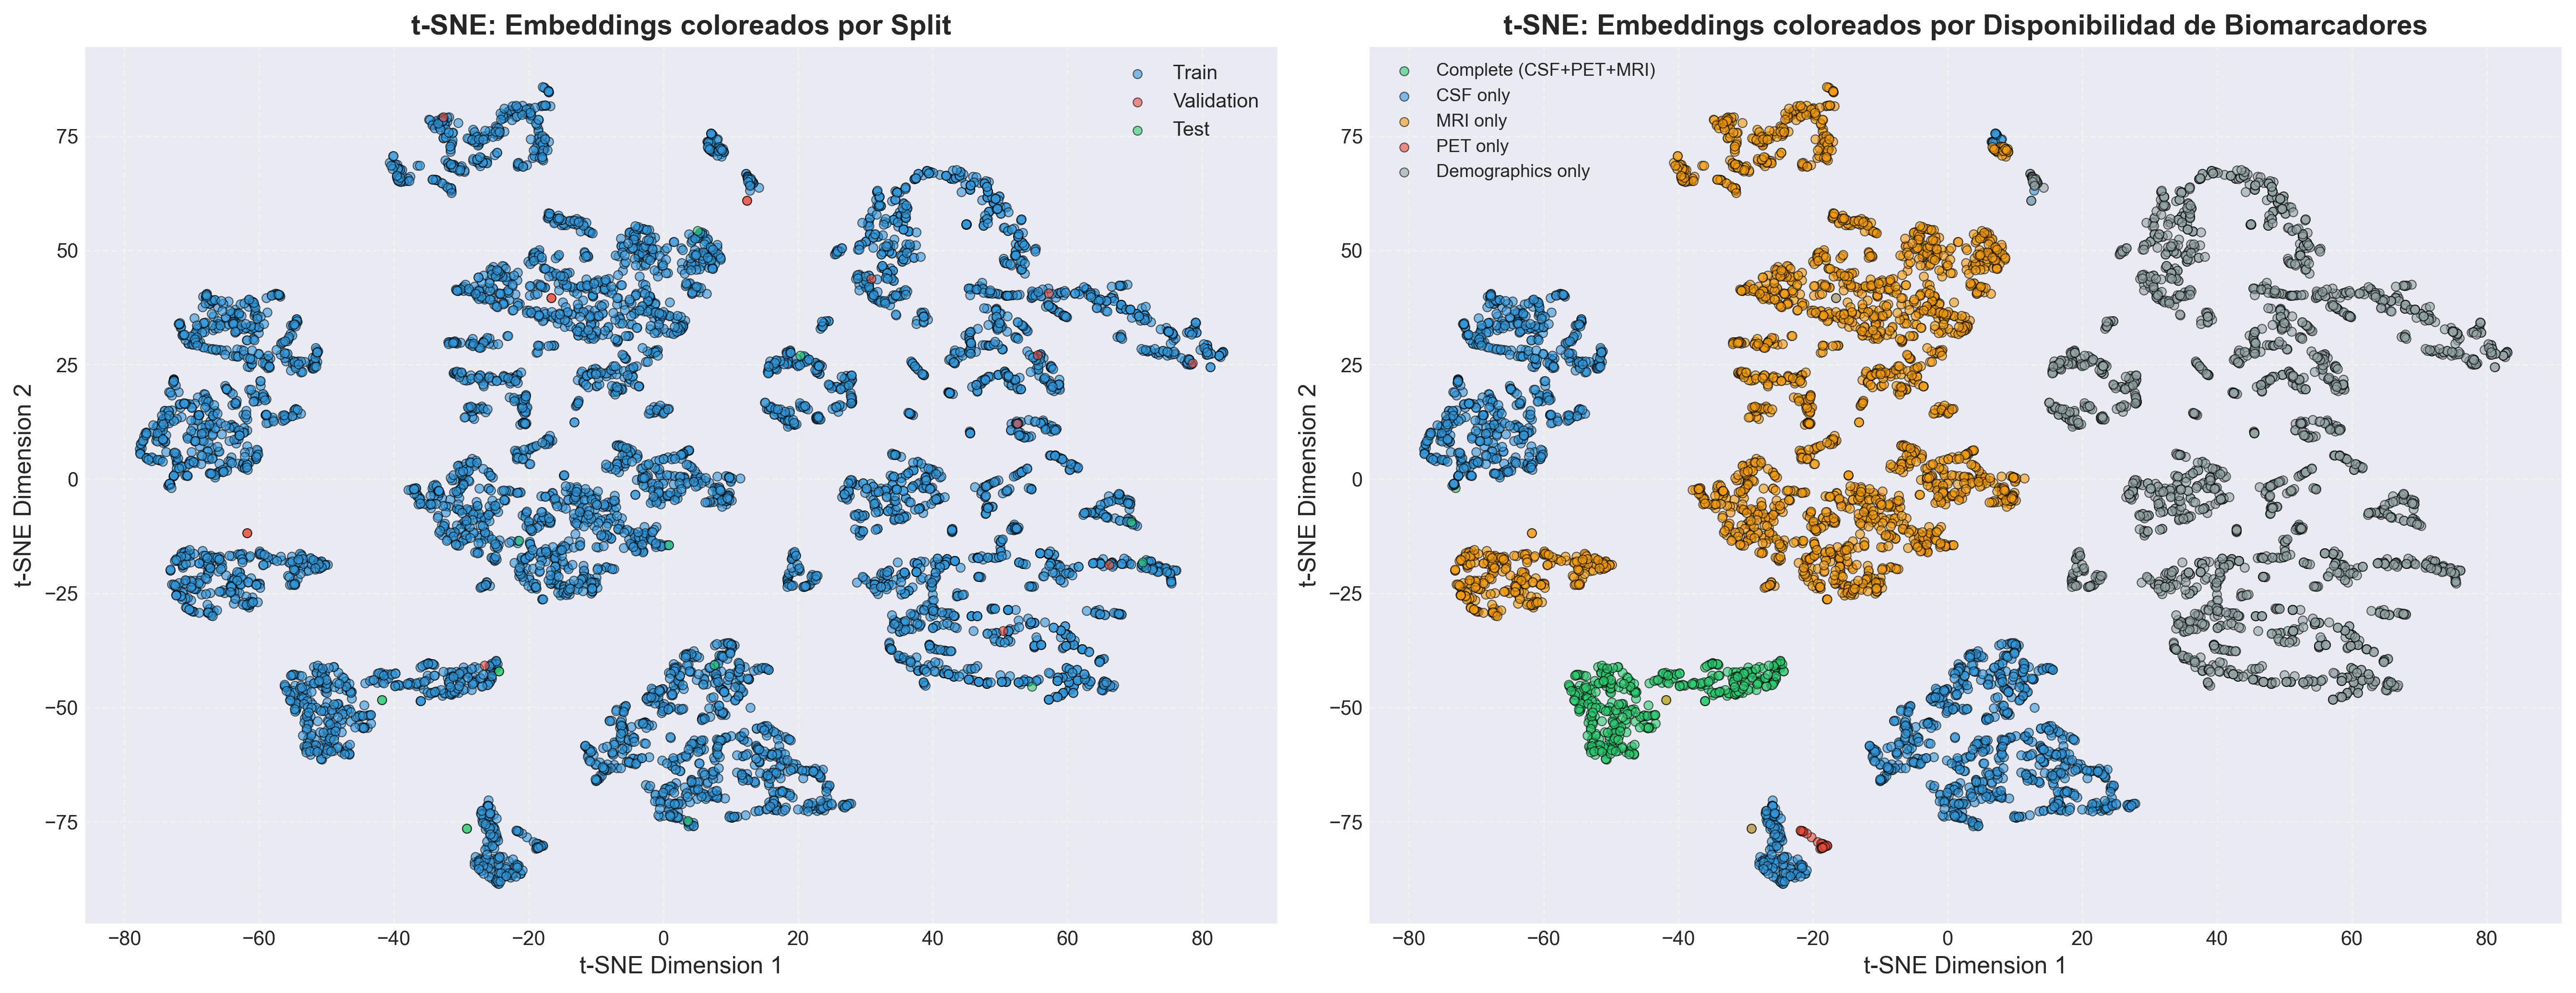


✅ Gráfico guardado: interpretable_tsne_embeddings.png


In [35]:

print("\n🔄 Ejecutando t-SNE (puede tardar unos minutos)...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000)
embeddings_2d_tsne = tsne.fit_transform(embeddings)

print("✅ t-SNE completado")

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

for split, color, label in [("train", "#3498db", "Train"), 
                             ("val", "#e74c3c", "Validation"), 
                             ("test", "#2ecc71", "Test")]:
    mask = node_split == split
    axes[0].scatter(embeddings_2d_tsne[mask, 0], embeddings_2d_tsne[mask, 1], 
                   c=color, label=label, alpha=0.6, s=20, edgecolors='black', linewidths=0.5)

axes[0].set_title('t-SNE: Embeddings coloreados por Split', fontsize=14, fontweight='bold')
axes[0].set_xlabel('t-SNE Dimension 1', fontsize=12)
axes[0].set_ylabel('t-SNE Dimension 2', fontsize=12)
axes[0].legend(fontsize=10, loc='best')
axes[0].grid(True, alpha=0.3, linestyle='--')

category_colors = {
    'Complete (CSF+PET+MRI)': '#2ecc71',
    'CSF only': '#3498db',
    'MRI only': '#f39c12',
    'PET only': '#e74c3c',
    'Demographics only': '#95a5a6'
}

for cat, color in category_colors.items():
    mask = biomarker_category == cat
    if mask.any():
        axes[1].scatter(embeddings_2d_tsne[mask, 0], embeddings_2d_tsne[mask, 1], 
                       c=color, label=cat, alpha=0.6, s=20, edgecolors='black', linewidths=0.5)

axes[1].set_title('t-SNE: Embeddings coloreados por Disponibilidad de Biomarcadores', 
                 fontsize=14, fontweight='bold')
axes[1].set_xlabel('t-SNE Dimension 1', fontsize=12)
axes[1].set_ylabel('t-SNE Dimension 2', fontsize=12)
axes[1].legend(fontsize=9, loc='best')
axes[1].grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig('interpretable_tsne_embeddings.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Gráfico guardado: interpretable_tsne_embeddings.png")


🔄 Ejecutando UMAP...


d:\VSCode\tfm-gnn\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


✅ UMAP completado


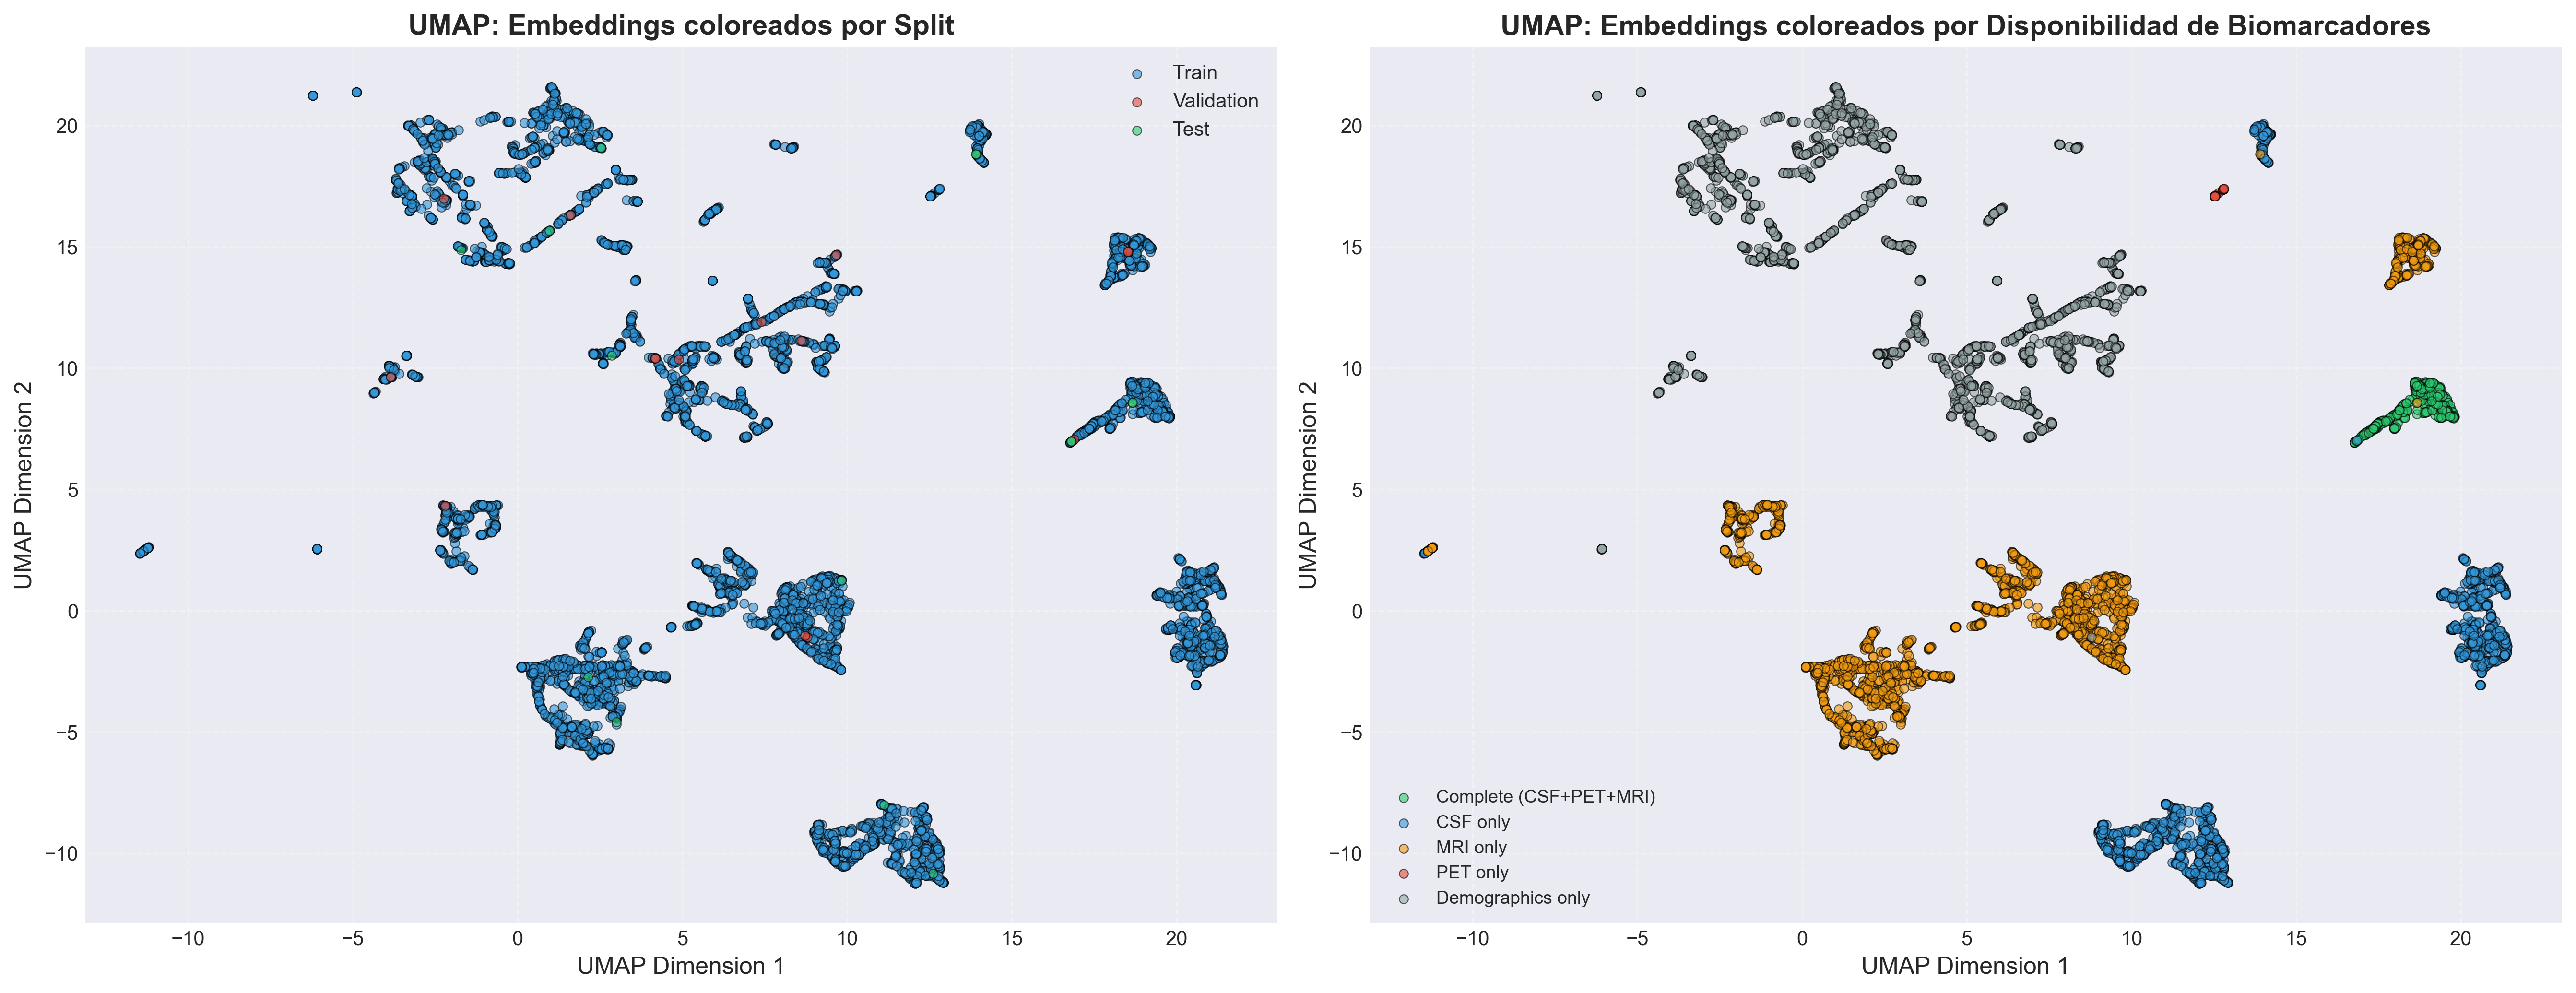


✅ Gráfico guardado: interpretable_umap_embeddings.png


In [36]:

if UMAP_AVAILABLE:
    print("\n🔄 Ejecutando UMAP...")
    reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1)
    embeddings_2d_umap = reducer.fit_transform(embeddings)
    print("✅ UMAP completado")
    
    fig, axes = plt.subplots(1, 2, figsize=(18, 7))
    
    for split, color, label in [("train", "#3498db", "Train"), 
                                 ("val", "#e74c3c", "Validation"), 
                                 ("test", "#2ecc71", "Test")]:
        mask = node_split == split
        axes[0].scatter(embeddings_2d_umap[mask, 0], embeddings_2d_umap[mask, 1], 
                       c=color, label=label, alpha=0.6, s=20, edgecolors='black', linewidths=0.5)
    
    axes[0].set_title('UMAP: Embeddings coloreados por Split', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('UMAP Dimension 1', fontsize=12)
    axes[0].set_ylabel('UMAP Dimension 2', fontsize=12)
    axes[0].legend(fontsize=10, loc='best')
    axes[0].grid(True, alpha=0.3, linestyle='--')
    
    for cat, color in category_colors.items():
        mask = biomarker_category == cat
        if mask.any():
            axes[1].scatter(embeddings_2d_umap[mask, 0], embeddings_2d_umap[mask, 1], 
                           c=color, label=cat, alpha=0.6, s=20, edgecolors='black', linewidths=0.5)
    
    axes[1].set_title('UMAP: Embeddings coloreados por Disponibilidad de Biomarcadores', 
                     fontsize=14, fontweight='bold')
    axes[1].set_xlabel('UMAP Dimension 1', fontsize=12)
    axes[1].set_ylabel('UMAP Dimension 2', fontsize=12)
    axes[1].legend(fontsize=9, loc='best')
    axes[1].grid(True, alpha=0.3, linestyle='--')
    
    plt.tight_layout()
    plt.savefig('interpretable_umap_embeddings.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\n✅ Gráfico guardado: interpretable_umap_embeddings.png")
else:
    print("\n⚠️  UMAP no disponible. Instala con: pip install umap-learn")

## 3. Visualización 2: Análisis de Importancia de Características

In [37]:

print("\n🔍 Analizando importancia de características mediante ablación...")

model.eval()
with torch.no_grad():
    out_baseline = model(data.x, data.edge_index)
    baseline_mae = torch.mean(torch.abs(out_baseline[data.test_mask] - data.y[data.test_mask])).item() * y_std

print(f"\nBaseline (todas las features): Test MAE = {baseline_mae:.4f} años")

feature_groups = {
    'Demographics (Age, Education)': ['AGE_AT_VISIT', 'PTEDUCAT'],
    'CSF Biomarkers': [c for c in csf_cols if c in X_clean.columns],
    'PET Imaging': [c for c in pet_cols if c in X_clean.columns],
    'MRI Volumetric': [c for c in mri_cols if c in X_clean.columns],
    'Missing Indicators': [c for c in missing_indicators if c in X_clean.columns],
    'Categorical (Gender, Marital)': [c for c in X_clean.columns if c.startswith('PTGENDER_') or c.startswith('PTMARRY_')]
}

ablation_results = {}

for group_name, features in feature_groups.items():
    if not features:
        continue
    
    x_ablated = data.x.clone()
    feature_indices = [X_clean.columns.tolist().index(f) for f in features if f in X_clean.columns]
    x_ablated[:, feature_indices] = 0.0
    
    with torch.no_grad():
        out_ablated = model(x_ablated, data.edge_index)
        ablated_mae = torch.mean(torch.abs(out_ablated[data.test_mask] - data.y[data.test_mask])).item() * y_std
    
    degradation = ablated_mae - baseline_mae
    degradation_pct = (degradation / baseline_mae) * 100
    
    ablation_results[group_name] = {
        'mae': ablated_mae,
        'degradation': degradation,
        'degradation_pct': degradation_pct
    }
    
    print(f"\n{group_name}:")
    print(f"  Features: {len(features)}")
    print(f"  MAE sin grupo: {ablated_mae:.4f} años")
    print(f"  Degradación: {degradation:+.4f} años ({degradation_pct:+.1f}%)")

sorted_groups = sorted(ablation_results.items(), key=lambda x: x[1]['degradation'], reverse=True)

print("\n" + "="*70)
print("📊 Ranking de Importancia de Características")
print("="*70)
for i, (group, results) in enumerate(sorted_groups, 1):
    print(f"{i}. {group}: {results['degradation']:+.4f} años ({results['degradation_pct']:+.1f}%)")


🔍 Analizando importancia de características mediante ablación...

Baseline (todas las features): Test MAE = 0.0636 años

Demographics (Age, Education):
  Features: 2
  MAE sin grupo: 0.0579 años
  Degradación: -0.0057 años (-9.0%)

CSF Biomarkers:
  Features: 6
  MAE sin grupo: 0.0907 años
  Degradación: +0.0271 años (+42.6%)

PET Imaging:
  Features: 3
  MAE sin grupo: 0.0567 años
  Degradación: -0.0069 años (-10.8%)

MRI Volumetric:
  Features: 7
  MAE sin grupo: 0.0811 años
  Degradación: +0.0175 años (+27.5%)

Missing Indicators:
  Features: 3
  MAE sin grupo: 0.0699 años
  Degradación: +0.0063 años (+9.8%)

Categorical (Gender, Marital):
  Features: 7
  MAE sin grupo: 0.0608 años
  Degradación: -0.0028 años (-4.5%)

📊 Ranking de Importancia de Características
1. CSF Biomarkers: +0.0271 años (+42.6%)
2. MRI Volumetric: +0.0175 años (+27.5%)
3. Missing Indicators: +0.0063 años (+9.8%)
4. Categorical (Gender, Marital): -0.0028 años (-4.5%)
5. Demographics (Age, Education): -0.0057 a

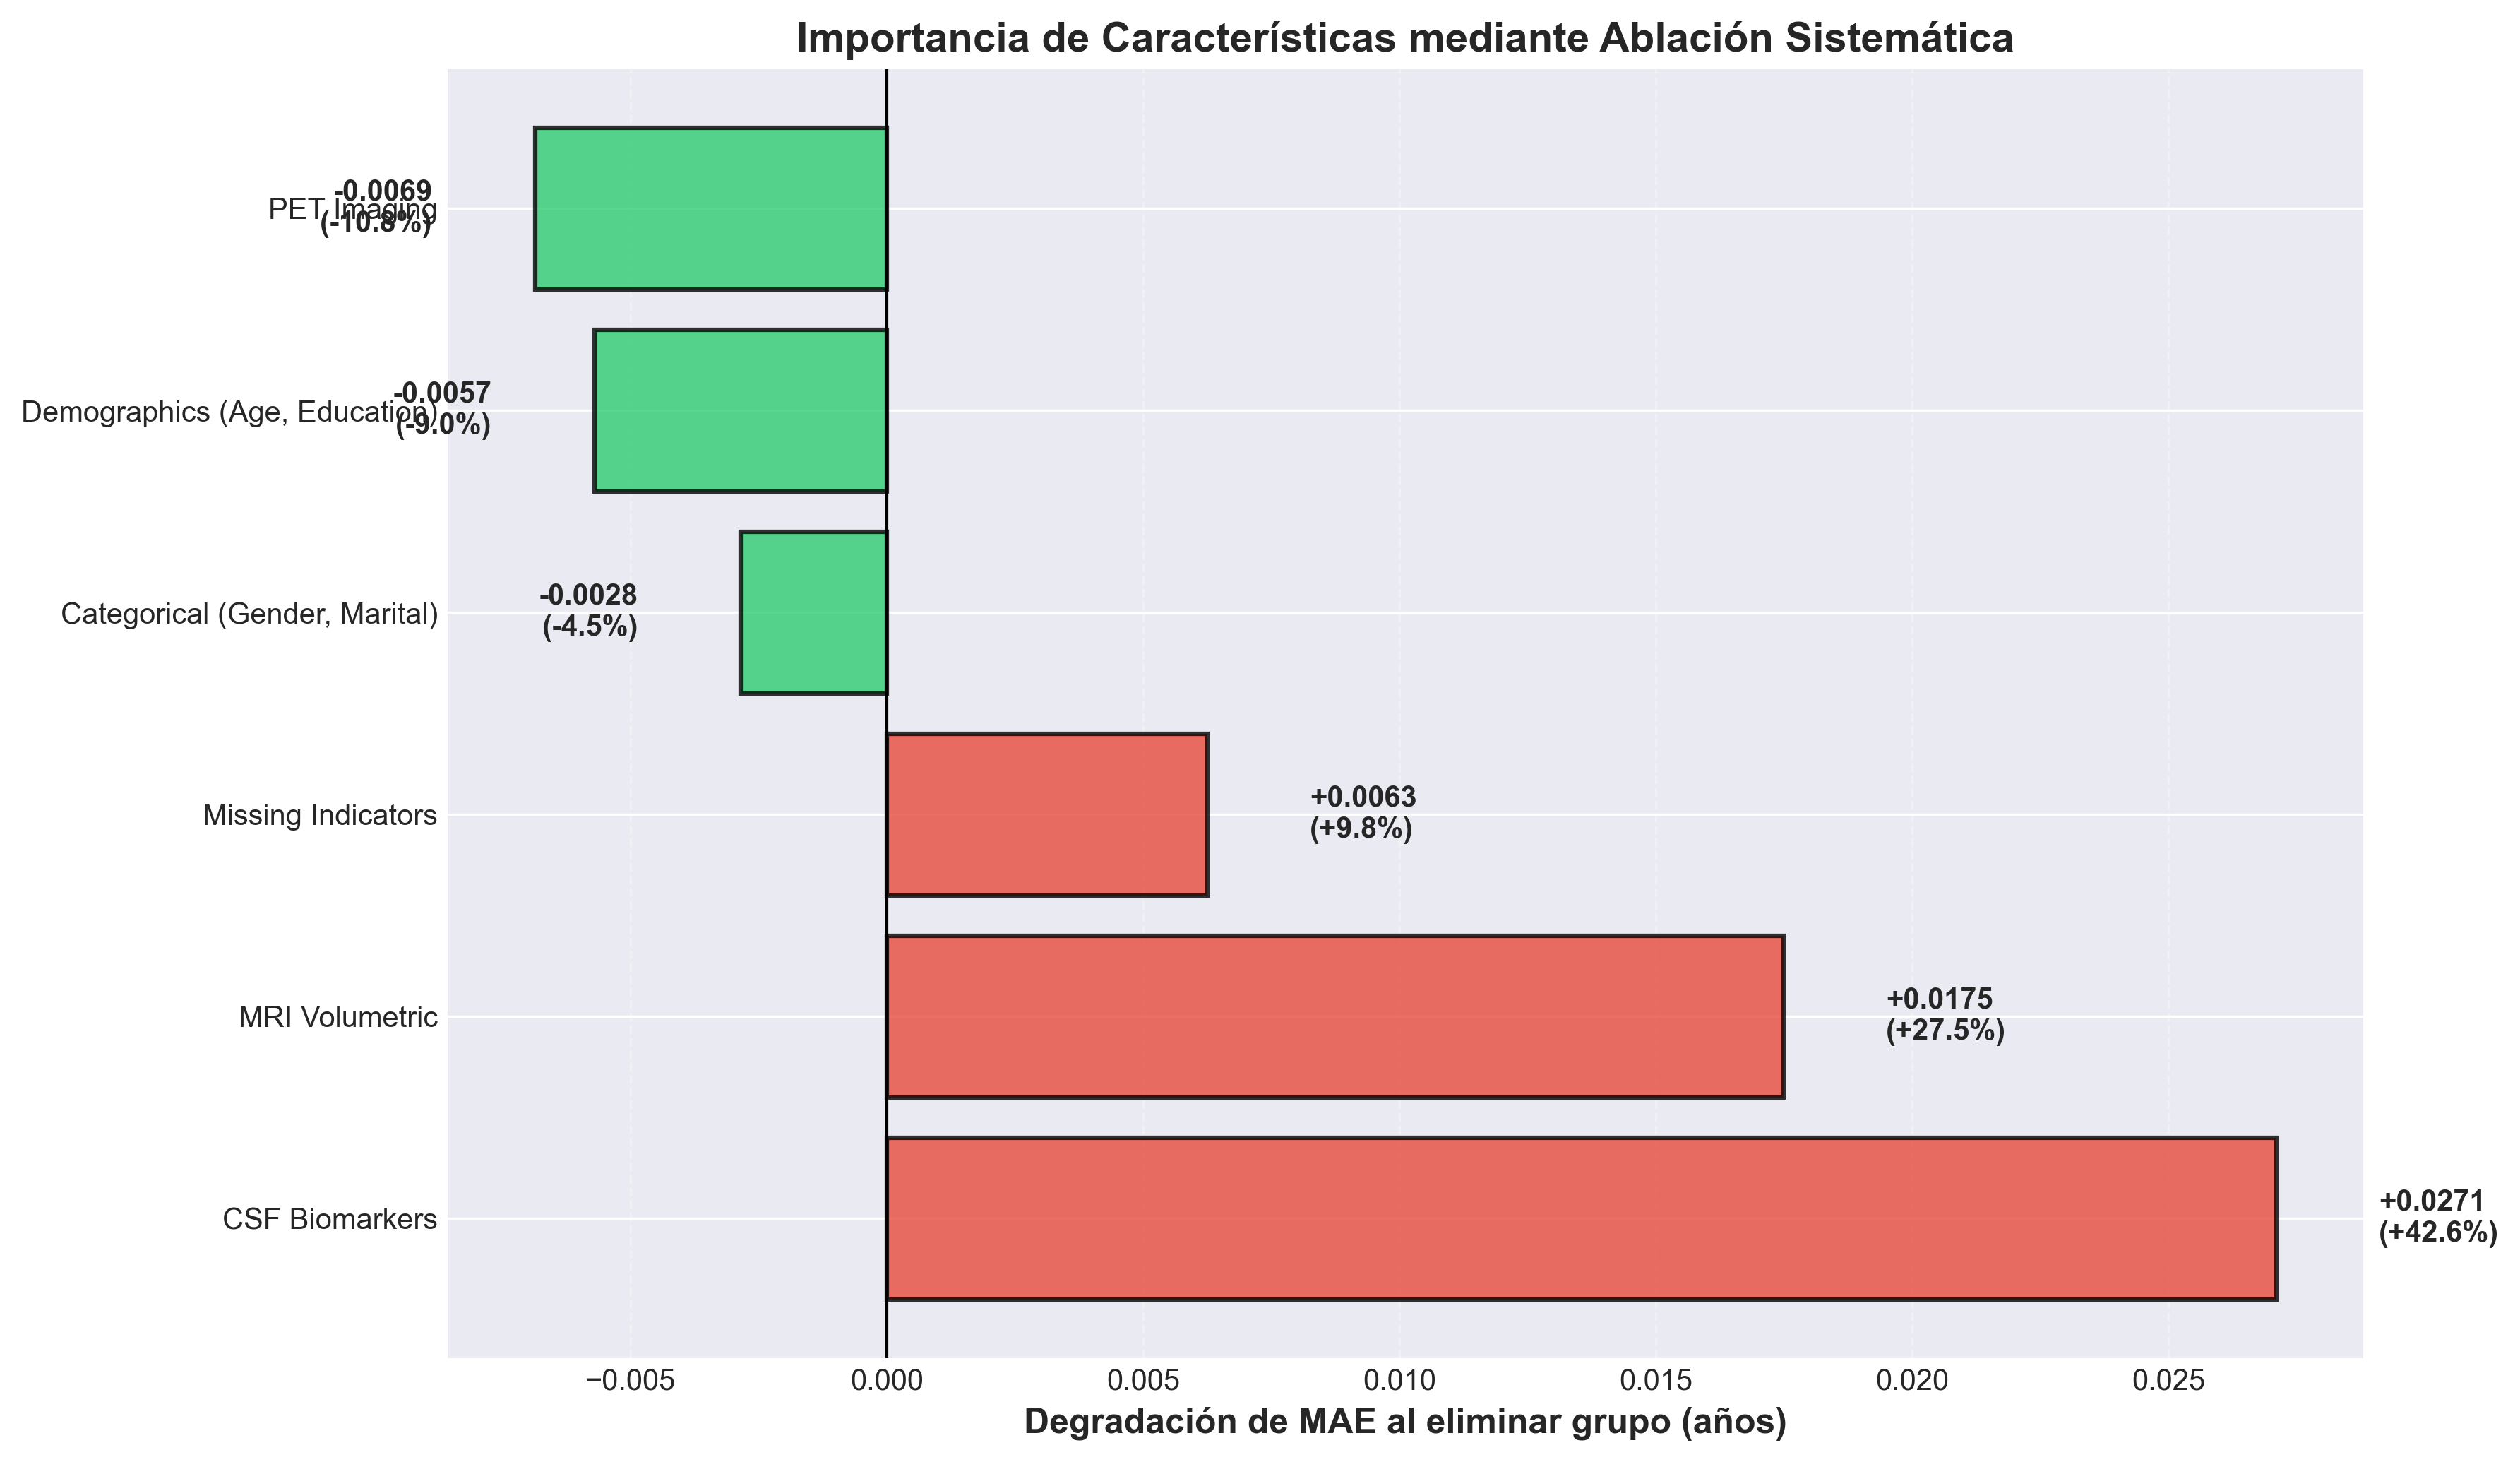


✅ Gráfico guardado: interpretable_feature_importance.png


In [38]:

fig, ax = plt.subplots(figsize=(12, 7))

groups = [item[0] for item in sorted_groups]
degradations = [item[1]['degradation'] for item in sorted_groups]
degradations_pct = [item[1]['degradation_pct'] for item in sorted_groups]

colors = ['#e74c3c' if d > 0 else '#2ecc71' for d in degradations]

bars = ax.barh(groups, degradations, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)

ax.set_xlabel('Degradación de MAE al eliminar grupo (años)', fontsize=12, fontweight='bold')
ax.set_title('Importancia de Características mediante Ablación Sistemática', 
             fontsize=14, fontweight='bold')
ax.axvline(0, color='black', linewidth=1, linestyle='-')
ax.grid(axis='x', alpha=0.3, linestyle='--')

for bar, val, pct in zip(bars, degradations, degradations_pct):
    width = bar.get_width()
    ax.text(width + (0.002 if width > 0 else -0.002), bar.get_y() + bar.get_height()/2.,
           f'{val:+.4f}\n({pct:+.1f}%)',
           ha='left' if width > 0 else 'right', va='center', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.savefig('interpretable_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Gráfico guardado: interpretable_feature_importance.png")

## 4. Visualización 3: Estructura del Grafo

Generando visualizacion del grafo...
   Nodos en el grafo: 127 de 200 candidatos


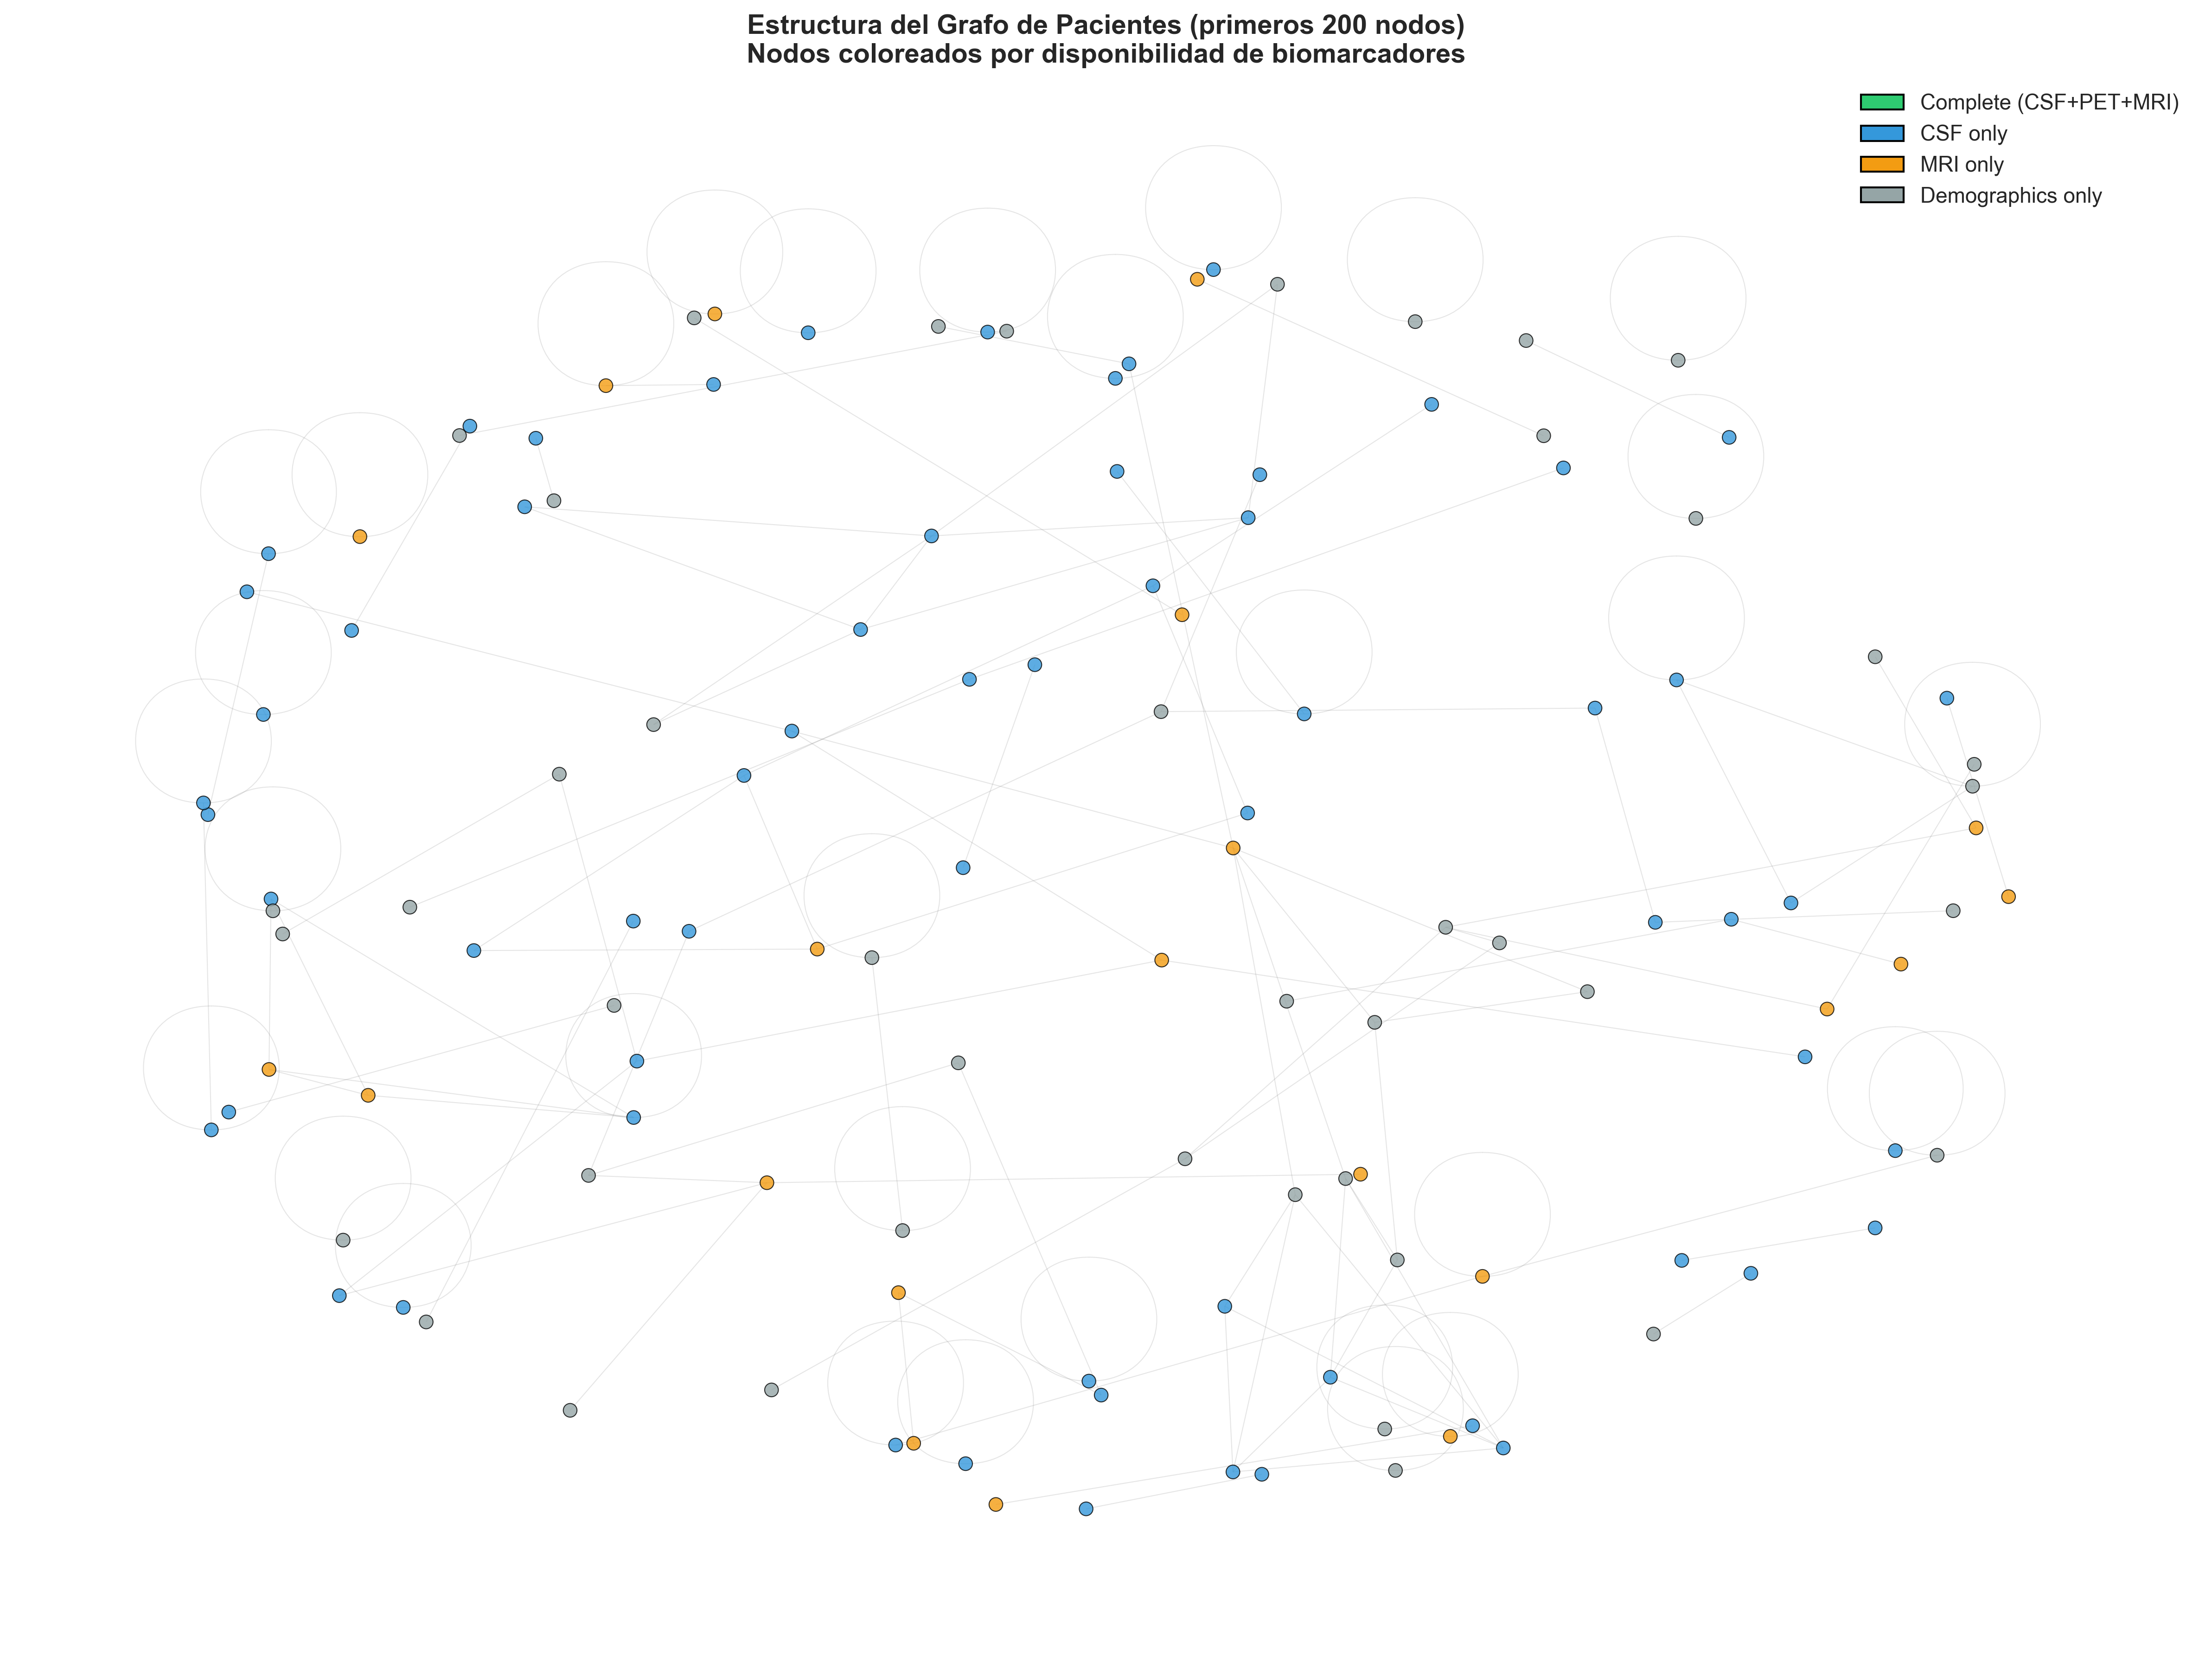

Grafico guardado: interpretable_graph_structure.png
   Nodos visualizados: 127
   Aristas visualizadas: 132


In [41]:

print("Generando visualizacion del grafo...")

n_nodes_viz = min(200, len(df))

edge_list = edge_index.t().cpu().numpy()
edges_subset = [(u, v) for u, v in edge_list if u < n_nodes_viz and v < n_nodes_viz]

G = nx.Graph()
G.add_edges_from(edges_subset)

actual_nodes = sorted(G.nodes())
print(f"   Nodos en el grafo: {len(actual_nodes)} de {n_nodes_viz} candidatos")

pos = nx.spring_layout(G, seed=42, k=0.5, iterations=50)

node_colors = []
for node_id in actual_nodes:
    if has_csf[node_id] and has_pet[node_id] and has_mri[node_id]:
        node_colors.append('#2ecc71')  # Verde: completo
    elif has_csf[node_id]:
        node_colors.append('#3498db')  # Azul: CSF
    elif has_mri[node_id]:
        node_colors.append('#f39c12')  # Naranja: MRI
    else:
        node_colors.append('#95a5a6')  # Gris: solo demografia

fig, ax = plt.subplots(figsize=(16, 12))

nx.draw_networkx_edges(G, pos, alpha=0.2, width=0.5, edge_color='gray', ax=ax)
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=50, 
                       alpha=0.8, edgecolors='black', linewidths=0.5, ax=ax)

from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#2ecc71', edgecolor='black', label='Complete (CSF+PET+MRI)'),
    Patch(facecolor='#3498db', edgecolor='black', label='CSF only'),
    Patch(facecolor='#f39c12', edgecolor='black', label='MRI only'),
    Patch(facecolor='#95a5a6', edgecolor='black', label='Demographics only')
]
ax.legend(handles=legend_elements, loc='upper right', fontsize=11)

ax.set_title(f'Estructura del Grafo de Pacientes (primeros {n_nodes_viz} nodos)\n'
             f'Nodos coloreados por disponibilidad de biomarcadores',
             fontsize=14, fontweight='bold')
ax.axis('off')

plt.tight_layout()
plt.savefig('interpretable_graph_structure.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Grafico guardado: interpretable_graph_structure.png")
print(f"   Nodos visualizados: {len(G.nodes())}")
print(f"   Aristas visualizadas: {len(G.edges())}")

## 5. Visualización 4: Trayectorias Longitudinales de Pacientes


🔍 Analizando trayectorias longitudinales de pacientes...

Pacientes seleccionados: 10


C:\Users\merit\AppData\Local\Temp\ipykernel_4192\1700163203.py:55: UserWarning: Glyph 9724 (\N{BLACK MEDIUM SQUARE}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\merit\AppData\Local\Temp\ipykernel_4192\1700163203.py:55: UserWarning: Glyph 9733 (\N{BLACK STAR}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\merit\AppData\Local\Temp\ipykernel_4192\1700163203.py:56: UserWarning: Glyph 9724 (\N{BLACK MEDIUM SQUARE}) missing from font(s) Arial.
  plt.savefig('interpretable_patient_trajectories.png', dpi=300, bbox_inches='tight')
C:\Users\merit\AppData\Local\Temp\ipykernel_4192\1700163203.py:56: UserWarning: Glyph 9733 (\N{BLACK STAR}) missing from font(s) Arial.
  plt.savefig('interpretable_patient_trajectories.png', dpi=300, bbox_inches='tight')
d:\VSCode\tfm-gnn\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9724 (\N{BLACK MEDIUM SQUARE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
d:\VSCode\tfm-gnn\.venv\Lib\si

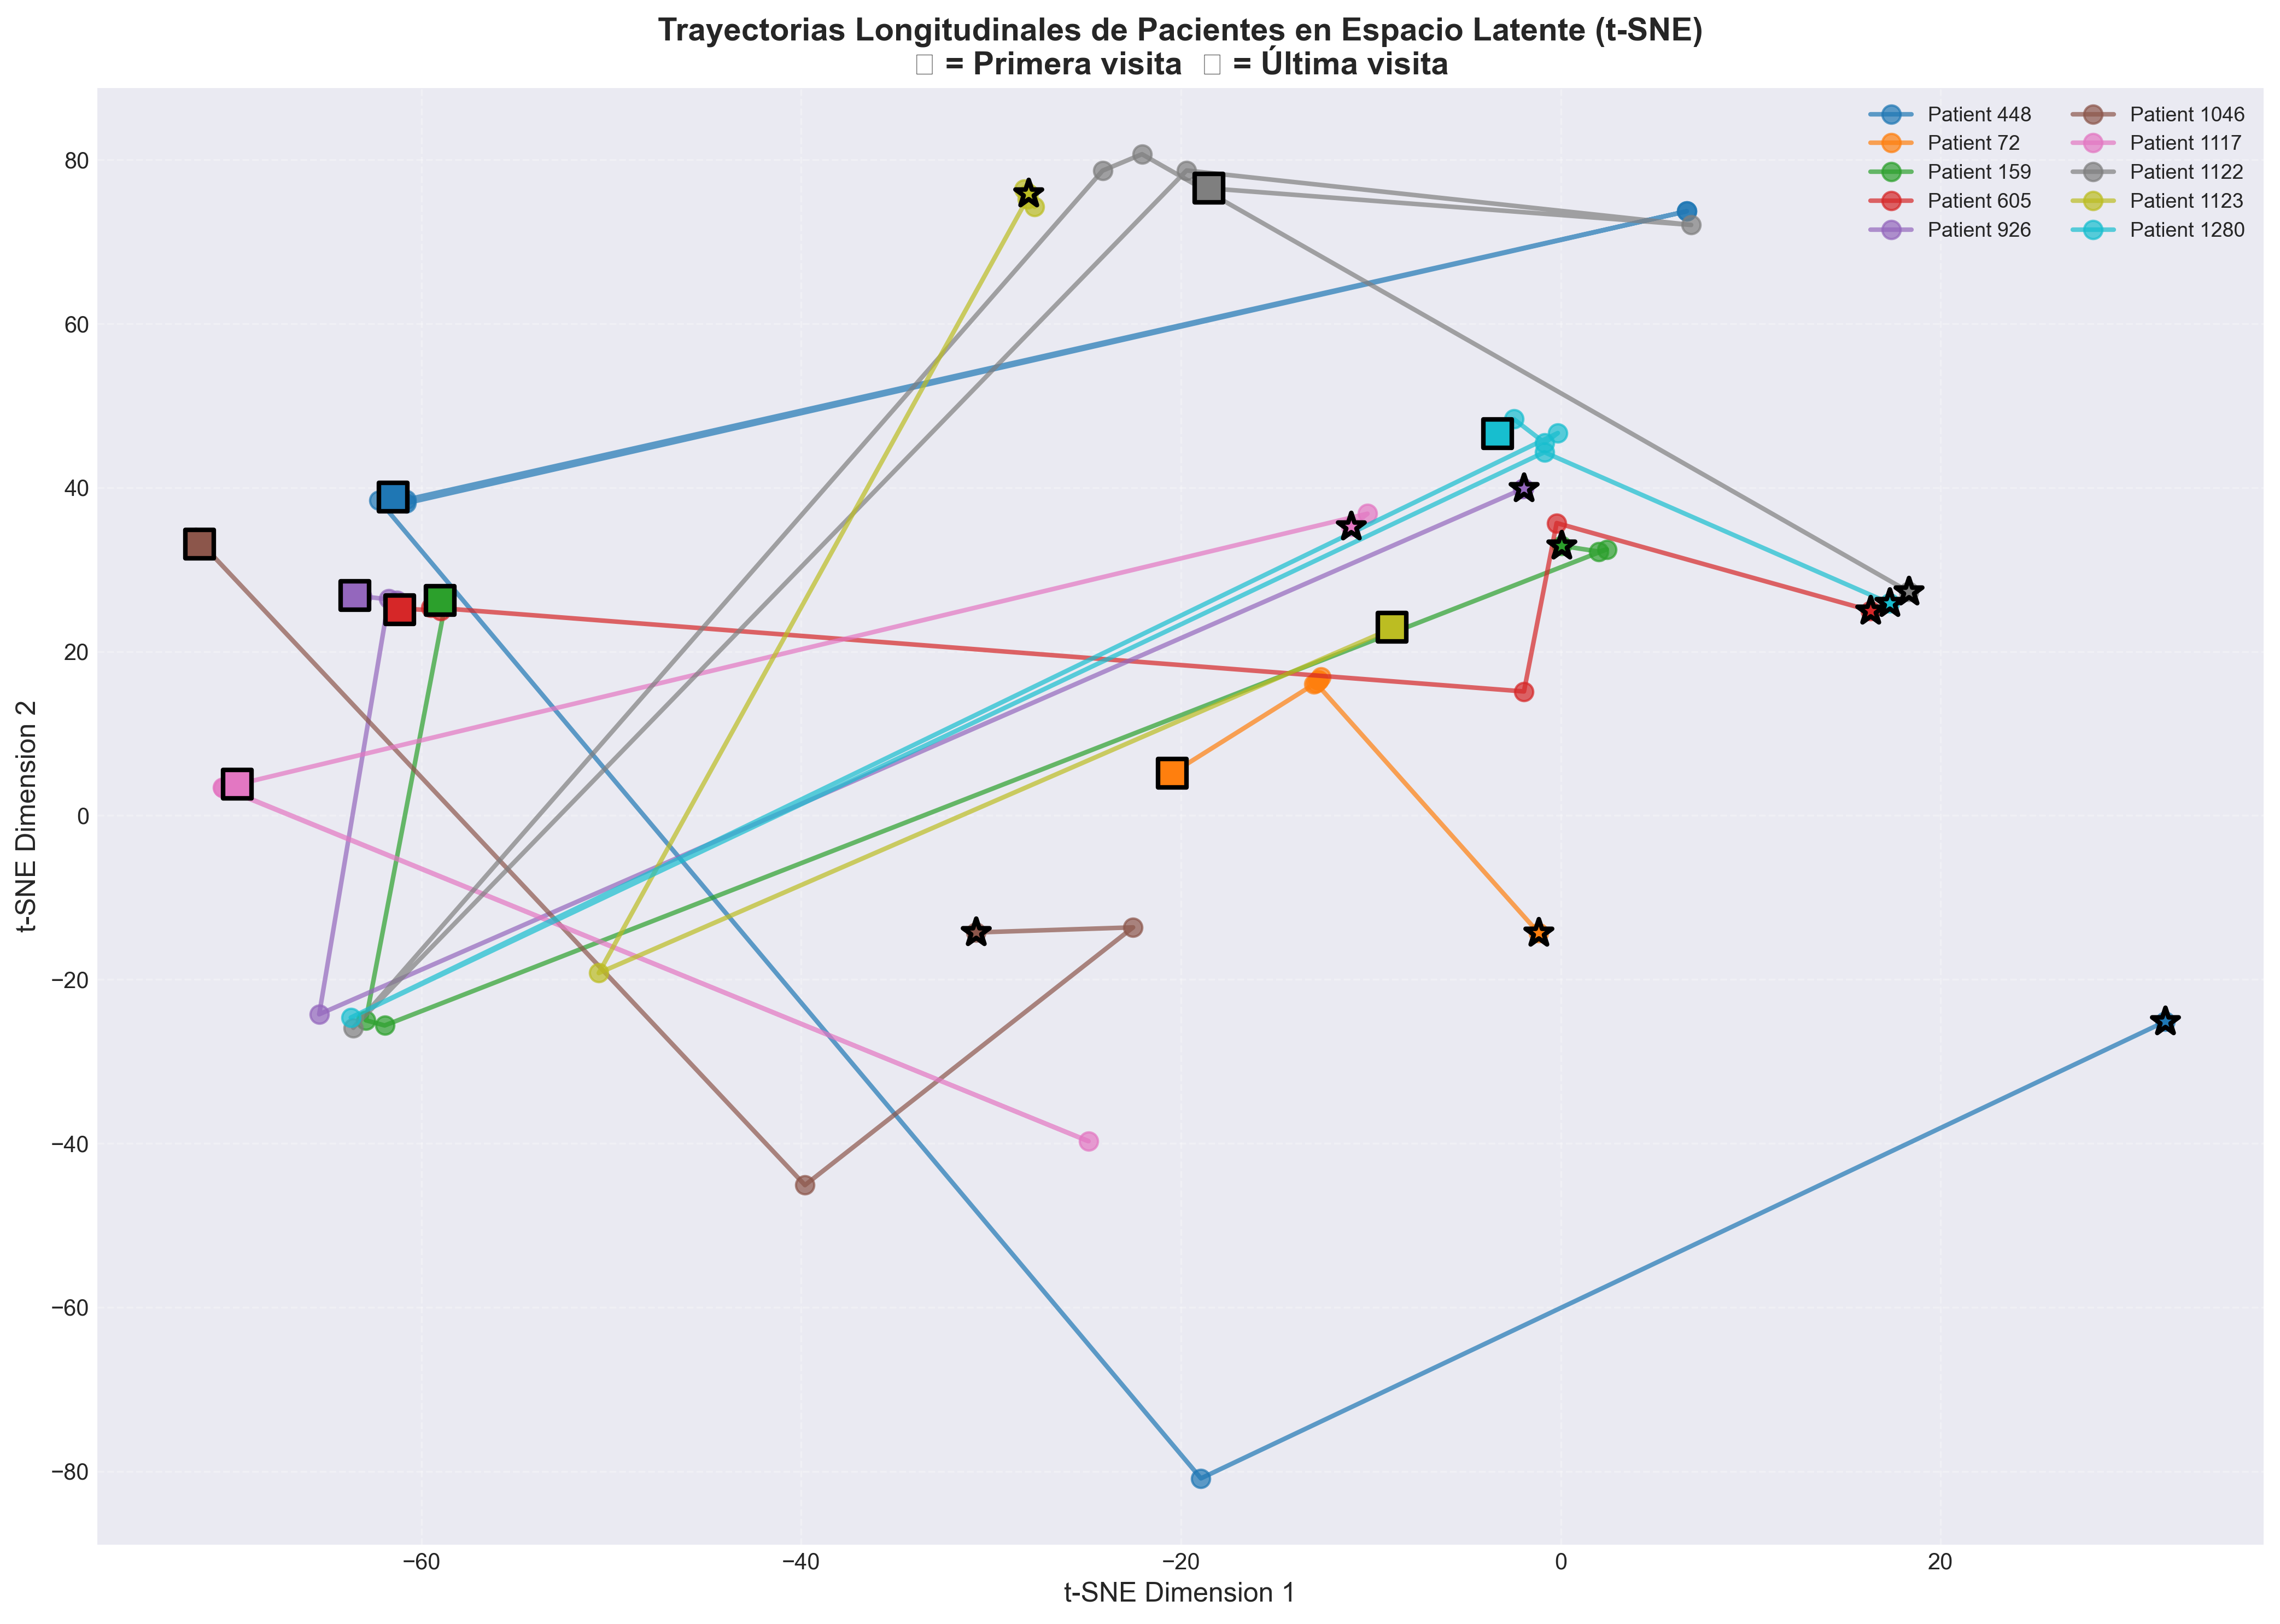


✅ Gráfico guardado: interpretable_patient_trajectories.png

📊 Estadísticas de trayectorias:
  Patient 448: 8 visitas en 6.0 años
  Patient 72: 7 visitas en 18.7 años
  Patient 159: 7 visitas en 6.1 años
  Patient 605: 7 visitas en 18.2 años
  Patient 926: 7 visitas en 5.2 años


In [42]:

print("\n🔍 Analizando trayectorias longitudinales de pacientes...")

df_with_idx = df.reset_index()
df_with_idx['node_idx'] = df_with_idx.index

patient_visits = df_with_idx.groupby('RID').filter(lambda x: len(x) >= 3)
patient_groups = patient_visits.groupby('RID')

top_patients = patient_groups.size().nlargest(10).index.tolist()

print(f"\nPacientes seleccionados: {len(top_patients)}")

if 'embeddings_2d_tsne' not in locals():
    print("Ejecutando t-SNE para trayectorias...")
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    embeddings_2d_tsne = tsne.fit_transform(embeddings)

fig, ax = plt.subplots(figsize=(14, 10))

colors_patients = plt.cm.tab10(np.linspace(0, 1, len(top_patients)))

for patient_id, color in zip(top_patients, colors_patients):
    patient_data = patient_visits[patient_visits['RID'] == patient_id].sort_values(date_col)
    node_indices = patient_data['node_idx'].values
    
    coords = embeddings_2d_tsne[node_indices]
    
    ax.plot(coords[:, 0], coords[:, 1], '-o', color=color, linewidth=2, 
            markersize=8, alpha=0.7, label=f'Patient {patient_id}')
    
    ax.scatter(coords[0, 0], coords[0, 1], color=color, s=150, marker='s', 
               edgecolors='black', linewidths=2, alpha=1.0, zorder=10)
    ax.scatter(coords[-1, 0], coords[-1, 1], color=color, s=150, marker='*', 
               edgecolors='black', linewidths=2, alpha=1.0, zorder=10)

ax.set_title('Trayectorias Longitudinales de Pacientes en Espacio Latente (t-SNE)\n'
             '◼ = Primera visita  ★ = Última visita',
             fontsize=14, fontweight='bold')
ax.set_xlabel('t-SNE Dimension 1', fontsize=12)
ax.set_ylabel('t-SNE Dimension 2', fontsize=12)
ax.legend(fontsize=9, loc='best', ncol=2)
ax.grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig('interpretable_patient_trajectories.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Gráfico guardado: interpretable_patient_trajectories.png")

print("\n📊 Estadísticas de trayectorias:")
for patient_id in top_patients[:5]:  # Mostrar solo primeros 5
    patient_data = patient_visits[patient_visits['RID'] == patient_id].sort_values(date_col)
    n_visits = len(patient_data)
    span_years = (patient_data[date_col].max() - patient_data[date_col].min()).days / 365.25
    print(f"  Patient {patient_id}: {n_visits} visitas en {span_years:.1f} años")

## 6. Resumen y Exportación de Resultados

In [43]:

print("\n" + "="*70)
print("📊 RESUMEN DE VISUALIZACIONES INTERPRETABLES (OBJETIVO 7)")
print("="*70)

print("\n✅ Visualizaciones generadas:")
print("   1. interpretable_tsne_embeddings.png")
print("      - Proyección 2D del espacio latente de 64 dimensiones")
print("      - Coloreado por split y disponibilidad de biomarcadores")

if UMAP_AVAILABLE:
    print("   2. interpretable_umap_embeddings.png")
    print("      - Proyección UMAP alternativa")
    print("      - Mejor preservación de estructura local")

print("   3. interpretable_feature_importance.png")
print("      - Importancia relativa de cada modalidad mediante ablación")
print("      - Ranking cuantificado de contribución predictiva")

print("   4. interpretable_graph_structure.png")
print("      - Estructura de conectividad del grafo")
print("      - Visualización de propagación de información")

print("   5. interpretable_patient_trajectories.png")
print("      - Trayectorias longitudinales en espacio latente")
print("      - Evolución temporal de representaciones")

importance_summary = {
    'baseline_mae': baseline_mae,
    'feature_groups': {
        group: {
            'mae_without': results['mae'],
            'degradation_years': results['degradation'],
            'degradation_pct': results['degradation_pct']
        }
        for group, results in ablation_results.items()
    },
    'ranking': [group for group, _ in sorted_groups]
}

with open('feature_importance_analysis.json', 'w') as f:
    json.dump(importance_summary, f, indent=2)

print("\n✅ Resultados exportados: feature_importance_analysis.json")

print("\n" + "="*70)
print("🎓 OBJETIVO 7 CUMPLIDO")
print("="*70)
print("\nTodas las visualizaciones interpretables han sido generadas.")
print("Estos gráficos pueden incluirse directamente en la memoria del TFM.")


📊 RESUMEN DE VISUALIZACIONES INTERPRETABLES (OBJETIVO 7)

✅ Visualizaciones generadas:
   1. interpretable_tsne_embeddings.png
      - Proyección 2D del espacio latente de 64 dimensiones
      - Coloreado por split y disponibilidad de biomarcadores
   2. interpretable_umap_embeddings.png
      - Proyección UMAP alternativa
      - Mejor preservación de estructura local
   3. interpretable_feature_importance.png
      - Importancia relativa de cada modalidad mediante ablación
      - Ranking cuantificado de contribución predictiva
   4. interpretable_graph_structure.png
      - Estructura de conectividad del grafo
      - Visualización de propagación de información
   5. interpretable_patient_trajectories.png
      - Trayectorias longitudinales en espacio latente
      - Evolución temporal de representaciones

✅ Resultados exportados: feature_importance_analysis.json

🎓 OBJETIVO 7 CUMPLIDO

Todas las visualizaciones interpretables han sido generadas.
Estos gráficos pueden incluirse dir